In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.io import read_image
from tqdm import tqdm
import torchvision
import torch.nn as nn
from skimage import exposure
from skimage.exposure import match_histograms
torch.cuda.empty_cache()
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
import wandb

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="cxr_preprocessing",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "DenseNet",
    "dataset": "CheXpert",
    "epochs": 20,
    }
)

In [2]:
training_file_path =  r'..\..\datasets\CheXpert-v1.0-small\train.csv'
training_data = pd.read_csv(training_file_path)

In [3]:
training_data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [4]:
training_data.isnull().sum()

Path                               0
Sex                                0
Age                                0
Frontal/Lateral                    0
AP/PA                          32387
No Finding                    201033
Enlarged Cardiomediastinum    178575
Cardiomegaly                  177211
Lung Opacity                  105636
Lung Lesion                   211470
Edema                         137458
Consolidation                 152792
Pneumonia                     195806
Atelectasis                   154971
Pneumothorax                  144480
Pleural Effusion               90203
Pleural Other                 216922
Fracture                      211220
Support Devices               100197
dtype: int64

In [5]:
sample_image = r'..//..//datasets' + '/' + str(training_data['Path'][0])

In [6]:
img = plt.imread(sample_image)
img.dtype

dtype('uint8')

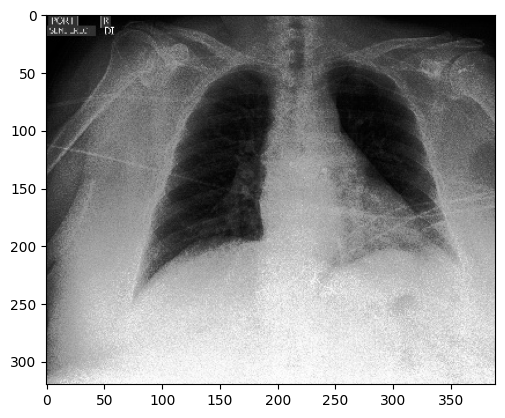

In [7]:
plt.imshow(img,cmap='gray')
plt.show()

In [8]:
demographic_data = pd.read_csv('..\\..\datasets\CheXpert-v1.0-small\demographics_CXP.csv')
demographic_data.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sutariya\AppData\Local\Temp\ipykernel_21972\1595071097.py:1: SyntaxWarning: invalid escape sequence '\d'
  demographic_data = pd.read_csv('..\\..\datasets\CheXpert-v1.0-small\demographics_CXP.csv')


,subject_id,race,ethnicity,insurance_type
0,42142,White,Non-Hispanic/Non-Latino,Private Insurance
1,4528,White,Non-Hispanic/Non-Latino,Private Insurance
2,55652,White,Non-Hispanic/Non-Latino,Medicare
3,53157,White,Non-Hispanic/Non-Latino,Medicare
4,11162,Asian,Non-Hispanic/Non-Latino,Medicare


In [9]:
len(demographic_data)

64725

In [10]:
path = training_data['Path']

In [11]:
patientid = []
for i in path:
     id = i.split(sep='/')[2]
     id = id.replace("patient", "")
     patientid.append(float(id))

In [12]:
patient = pd.DataFrame(patientid,columns=['patient_id'])

In [13]:
patient['patient_id'].nunique()

64540

In [14]:
demographic_data.nunique()

subject_id        64725
race                  8
ethnicity             4
insurance_type        5
dtype: int64

In [16]:
training_data['subject_id'] = patient['patient_id']

In [18]:
training_data.subject_id.nunique()

64540

In [19]:
training_data_merge = training_data.merge(demographic_data, on='subject_id')

In [20]:
training_data_merge.subject_id.nunique()

64525

In [21]:
def select_most_positive_sample(group):
    """
    Selects the row with the highest number of disease-positive labels from a group of records belonging to the same patient.
    If all records have zero disease labels, it selects one at random.
    """
    disease_columns = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture'
    ]
    
    # Count the number of positive disease labels for each sample
    group['positive_count'] = group[disease_columns].sum(axis=1)
    
    # Filter to only include rows where at least one disease is positive
    positive_cases = group[group['positive_count'] > 0]
    
    if not positive_cases.empty:
        # Select the sample with the highest number of positive labels
        selected_sample = positive_cases.loc[positive_cases['positive_count'].idxmax()]
    else:
        # If no disease-positive samples exist, pick one randomly
        selected_sample = group.sample(n=1).iloc[0]
    
    return selected_sample

def sampling_datasets(training_dataset):
    """
    Applies the sampling strategy: selecting one recording per patient (`subject_id`),
    preferring samples with at least one disease-positive label.
    """
    # Group by patient ID and apply the selection function
    training_dataset = training_dataset.groupby('subject_id', group_keys=False).apply(select_most_positive_sample)
    
    # Drop the temporary 'positive_count' column
    training_dataset.drop(columns=['positive_count'], inplace=True, errors='ignore')
    
    return training_dataset


In [22]:
training_data_sample_merge = sampling_datasets(training_data_merge)

C:\Users\sutariya\AppData\Local\Temp\ipykernel_21972\3186516309.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  training_dataset = training_dataset.groupby('subject_id', group_keys=False).apply(select_most_positive_sample)


In [23]:
training_data_sample_merge.subject_id.nunique()

64525

In [ ]:
training_data_merge['Frontal/Lateral'].value_counts()

In [ ]:
training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']] = training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']].replace(-1, 1)

In [ ]:
training_data_merge.isna().sum()

In [ ]:
training_data_merge.isna().sum()

In [ ]:
training_data_merge = training_data_merge[training_data_merge['Frontal/Lateral'] == 'Frontal']

In [ ]:
training_data_merge.fillna(0, inplace=True)

In [ ]:
training_data_merge.isna().sum()

In [ ]:
training_data

In [ ]:
training_data_merge.subject_id.nunique()

In [ ]:
len(training_data_merge)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx] / 255.0
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
data_images = []
for path in training_data_merge['Path']:
     full_path = '../../datasets' + '/' + str(path)
     img = read_image(full_path)
     data_images.append(img)

In [ ]:
top_5_races = training_data_merge['race'].value_counts().index[:5]
training_data_merge['race'] = training_data_merge['race'].where(training_data_merge['race'].isin(top_5_races))

In [ ]:
training_data_merge.race.value_counts()

In [ ]:
training_data_merge = pd.get_dummies(training_data_merge, columns=['race'], dtype=float)

In [ ]:
training_data_merge.columns

In [ ]:
labels = training_data_merge[['race_Asian', 'race_Black', 'race_Other', 'race_Unknown', 'race_White']].values
labels = torch.tensor(labels, dtype=torch.float32)


In [ ]:
labels = torch.argmax(labels, dim=1)
labels

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.Lambda(lambda i: i.repeat(3, 1, 1))
])

In [ ]:
class DenseNet_Model(nn.Module):
     def __init__(self, weights, out_feature):
          super().__init__()
          self.weight = weights
          self.out_feature = out_feature
          self.encoder = torchvision.models.densenet121(weights=weights)
          self.clf = nn.Linear(1000, out_feature)

     
     def encode(self, x):
          return self.encoder(x)

     def forward(self, x):
          z = self.encode(x)
          return self.clf(z)
     

In [ ]:
dataset = MyDataset(data_images,labels,transform)

In [ ]:
train_size = int(0.7 * len(dataset)) 
val_size = int(0.10 * len(dataset))  
test_size = len(dataset) - train_size - val_size  

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for label, img in train_loader:
     print(label.shape, img.shape)
     break

In [ ]:

import torch.nn as nn
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:

def log_roc_auc(y_true, y_scores, log=True, log_name="roc_auc_curve"):

    y_scores = np.array(y_scores)
    classes = np.unique(y_true) 
    y_true_bin = label_binarize(y_true, classes=classes)
    
    total_roc = 0

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 5))
    
    
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        total_roc += roc_auc
        ax.plot(fpr, tpr, lw=2, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

    # Plot settings
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Multi-Class ROC Curve")
    ax.legend(loc="lower right")

    # Log to wandb
    if log:
        wandb.log({log_name: wandb.Image(fig)})
    else:
        print(f"{log_name} : {total_roc/len(classes)}")

    # Close figure to free memory
    plt.close(fig)


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def model_training(model, train_loader, val_loader, num_epochs=10, device=None, is_binary=False):
    model = model.to(device)

    all_train_labels, all_train_preds = [], []
    all_val_labels, all_val_preds = [], []

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    early_stopper = EarlyStopper(patience=3)
    criterion = nn.BCEWithLogitsLoss() if is_binary else nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for inputs, tr_labels in train_loop:
            inputs, tr_labels = inputs.to(device), tr_labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).to(device)

            # Convert predictions & labels
            if is_binary:
                tr_labels = tr_labels.unsqueeze(dim=1)
                tr_preds = torch.sigmoid(outputs).detach().cpu().numpy()
            else:
                tr_preds = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            all_train_labels.extend(tr_labels.cpu().numpy())
            all_train_preds.extend(tr_preds)


            loss = criterion(outputs, tr_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            train_loop.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
        with torch.no_grad():
            for inputs, vl_labels in val_loop:
                inputs, vl_labels = inputs.to(device), vl_labels.to(device)

                outputs = model(inputs).to(device)
                if is_binary:
                    vl_labels = vl_labels.unsqueeze(dim=1)
                    vl_preds = torch.sigmoid(outputs).detach().cpu().numpy()
                else:
                    vl_preds = torch.softmax(outputs, dim=1).detach().cpu().numpy()

                all_val_labels.extend(vl_labels.cpu().numpy())
                all_val_preds.extend(vl_preds)

                loss = criterion(outputs, vl_labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Check for early stopping
        if early_stopper.early_stop(val_loss):
            break

        # Log metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        log_roc_auc(all_train_labels, all_train_preds, log=True, log_name='Training ROC-AUC')
        log_roc_auc(all_val_labels, all_val_preds, log=True, log_name='Validation ROC-AUC')

    # Final ROC-AUC Logging
    log_roc_auc(all_train_labels, all_train_preds, log=False, log_name='Training ROC-AUC')
    log_roc_auc(all_val_labels, all_val_preds, log=False, log_name='Validation ROC-AUC')



In [ ]:
weights = torch.load('no_finding_model_weights.pth', map_location='cpu')

In [ ]:
race_model = DenseNet_Model(weights=weights,out_feature=5)

In [ ]:
for param in race_model.encoder.parameters():
    param.requires_grad = False


In [ ]:
model_training(race_model,train_loader,val_loader,num_epochs=10,is_binary=False)

In [ ]:
torch.save(race_model.state_dict(), 'race_finding_model_weights.pth')

In [ ]:
test_model = DenseNet_Model(weights=None, out_feature=5)

In [ ]:
weights = torch.load('race_finding_model_weights.pth',map_location='cpu')

In [ ]:
test_model.load_state_dict(weights,strict=True)

In [ ]:
def testing_model(test_loader, model, device, is_binary=False):
    model.to(device)
    model.eval()

    all_test_labels, all_test_preds = [], []

    loader = tqdm(test_loader)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if is_binary:
                labels = labels.view(-1, 1)
                predicted = torch.sigmoid(outputs).detach().cpu().numpy()
            else:
                predicted = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(predicted)

    log_roc_auc(all_test_labels, all_test_preds, log=True, log_name='Testing ROC-AUC')
    log_roc_auc(all_test_labels, all_test_preds, log=False, log_name='Testing ROC-AUC')



In [ ]:
testing_model(test_loader,test_model,'cpu')